<a href="https://colab.research.google.com/github/jayantkp/Forecasting-System---Project-Demand-of-Products-at-a-Retail-Outlet-Based-on-Historical-Data/blob/main/Forecast_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries

In [1]:
pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import itertools
import seaborn as sns

Import the dataset

In [3]:
url = 'https://github.com/jayantkp/Forecasting-System---Project-Demand-of-Products-at-a-Retail-Outlet-Based-on-Historical-Data/blob/main/Dataset/data.xls?raw=true'
df = pd.read_excel(url, parse_dates = ['Order Date'])

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
#Check for missing values
df.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [6]:
#Check the columns present in the dataset
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [7]:
#Check the different types of product categories included
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

Creating dataframes for each product category

In [8]:
#data related to tech sales. 
tech = df.loc[df['Category'] == 'Technology']
tech

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,2016-01-16,2016-01-20,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,9984,US-2016-157728,2016-09-22,2016-09-28,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,TEC-PH-10001305,Technology,Phones,Panasonic KX TS208W Corded phone,97.980,2,0.0,27.4344
9986,9987,CA-2016-125794,2016-09-29,2016-10-03,Standard Class,ML-17410,Maris LaWare,Consumer,United States,Los Angeles,...,90008,West,TEC-AC-10003399,Technology,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.240,1,0.0,15.2208
9987,9988,CA-2017-163629,2017-11-17,2017-11-21,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-AC-10001539,Technology,Accessories,Logitech G430 Surround Sound Gaming Headset wi...,79.990,1,0.0,28.7964
9988,9989,CA-2017-163629,2017-11-17,2017-11-21,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-PH-10004006,Technology,Phones,Panasonic KX - TS880B Telephone,206.100,5,0.0,55.6470


In [9]:
#Keeping only the relevant columns in tech 
tech = tech[['Order Date','Sales']]
tech

,Order Date,Sales
7,2014-06-09,907.152
11,2014-06-09,911.424
19,2014-08-27,213.480
26,2016-01-16,90.570
35,2016-12-08,1097.544
...,...,...
9983,2016-09-22,97.980
9986,2016-09-29,36.240
9987,2017-11-17,79.990
9988,2017-11-17,206.100


In [10]:
#Sorting data according to order date
tech = tech.sort_values(by = 'Order Date')
tech

,Order Date,Sales
7478,2014-01-06,755.960
7477,2014-01-06,391.980
593,2014-01-09,31.200
765,2014-01-13,646.740
1913,2014-01-15,149.950
...,...,...
4924,2017-12-25,90.480
2569,2017-12-27,164.388
573,2017-12-28,14.850
1878,2017-12-29,302.376


In [11]:
#tech sales in each date
tech = tech.groupby('Order Date')['Sales'].sum().reset_index()
tech

,Order Date,Sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


In [12]:
tech.set_index('Order Date', inplace = True)

In [13]:
tech

,Sales
Order Date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


In [14]:
#Resampling the data into means of monthly sales
tech_y = tech['Sales'].resample('MS').mean()
tech_y

Order Date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

Creating a similar dataframe for office supplies

In [15]:
#data related to office supplies sales. 
off_sup = df.loc[df['Category'] == 'Office Supplies']
off_sup

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656
8,9,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.504,3,0.2,5.7825
9,10,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.900,5,0.0,34.4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,9983,US-2016-157728,2016-09-22,2016-09-28,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,OFF-PA-10002195,Office Supplies,Paper,"RSVP Cards & Envelopes, Blank White, 8-1/2"" X ...",35.560,7,0.0,16.7132
9984,9985,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,11561,East,OFF-LA-10003766,Office Supplies,Labels,Self-Adhesive Removable Labels,31.500,10,0.0,15.1200
9985,9986,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,11561,East,OFF-SU-10000898,Office Supplies,Supplies,Acme Hot Forged Carbon Steel Scissors with Nic...,55.600,4,0.0,16.1240
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,13.3200


In [16]:
#Keeping only the relevant columns in off_sup
off_sup = off_sup[['Order Date','Sales']]
off_sup

,Order Date,Sales
2,2016-06-12,14.620
4,2015-10-11,22.368
6,2014-06-09,7.280
8,2014-06-09,18.504
9,2014-06-09,114.900
...,...,...
9982,2016-09-22,35.560
9984,2015-05-17,31.500
9985,2015-05-17,55.600
9992,2017-02-26,29.600


In [17]:
#Sorting data according to order date
off_sup = off_sup.sort_values(by = 'Order Date')
off_sup

,Order Date,Sales
7980,2014-01-03,16.448
740,2014-01-04,272.736
739,2014-01-04,11.784
741,2014-01-04,3.540
1759,2014-01-05,19.536
...,...,...
5091,2017-12-30,3.024
1297,2017-12-30,20.720
908,2017-12-30,52.776
1296,2017-12-30,13.904


In [18]:
#office supplies sales in each date
off_sup = off_sup.groupby('Order Date')['Sales'].sum().reset_index()
off_sup

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430
...,...,...
1143,2017-12-26,814.594
1144,2017-12-27,13.248
1145,2017-12-28,1091.244
1146,2017-12-29,282.440


In [19]:
off_sup.set_index('Order Date', inplace = True)

In [20]:
#Resampling the data into means of monthly sales
office_y = off_sup['Sales'].resample('MS').mean()
office_y

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
2015-01-01     129.198571
2015-02-01     335.504188
2015-03-01     690.545522
2015-04-01     502.342320
2015-05-01     364.549440
2015-06-01     560.407737
2015-07-01     205.214739
2015-08-01     558.814667
2015-09-01     772.230680
2015-10-01     361.392083
2015-11-01     757.790357
2015-12-01     540.055800
2016-01-01     331.230125
2016-02-01     357.597368
2016-03-01     693.877240
2016-04-01     462.932478
2016-05-01     449.489724
2016-06-01     436.072400
2016-07-01     587.474727
2016-08-01     344.605385
2016-09-01     830.847786
2016-10-01     678.408083
2016-11-01     787.972231
2016-12-01    1357.055929
2017-01-01     967.013136
2017-02-01     389.882737
2

Creating a similar dataframe for furniture

In [21]:
#data related to furniture sales. 
furniture = df.loc[df['Category'] == 'Furniture']
furniture

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,9963,CA-2015-168088,2015-03-19,2015-03-22,First Class,CM-12655,Corinna Mitchell,Home Office,United States,Houston,...,77041,Central,FUR-BO-10004218,Furniture,Bookcases,Bush Heritage Pine Collection 5-Shelf Bookcase...,383.4656,4,0.32,-67.6704
9964,9965,CA-2016-146374,2016-12-05,2016-12-10,Second Class,HE-14800,Harold Engle,Corporate,United States,Newark,...,19711,East,FUR-FU-10002671,Furniture,Furnishings,Electrix 20W Halogen Replacement Bulb for Zoom...,13.4000,1,0.00,6.4320
9980,9981,US-2015-151435,2015-09-06,2015-09-09,Second Class,SW-20455,Shaun Weien,Consumer,United States,Lafayette,...,70506,South,FUR-TA-10001039,Furniture,Tables,KI Adjustable-Height Table,85.9800,1,0.00,22.3548
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028


In [22]:
#Keeping only the relevant columns in furniture
furniture = furniture[['Order Date','Sales']]
furniture

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840
...,...,...
9962,2015-03-19,383.4656
9964,2016-12-05,13.4000
9980,2015-09-06,85.9800
9989,2014-01-21,25.2480


In [23]:
#Sorting data according to order date
furniture = furniture.sort_values(by = 'Order Date')

In [24]:
#furniture sales in each date
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [25]:
furniture.set_index('Order Date', inplace = True)

In [26]:
#Resampling the data into means of monthly sales
furniture_y = furniture['Sales'].resample('MS').mean()
furniture_y

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

Plotting the sales data for each categories

Text(0, 0.5, 'Sales')

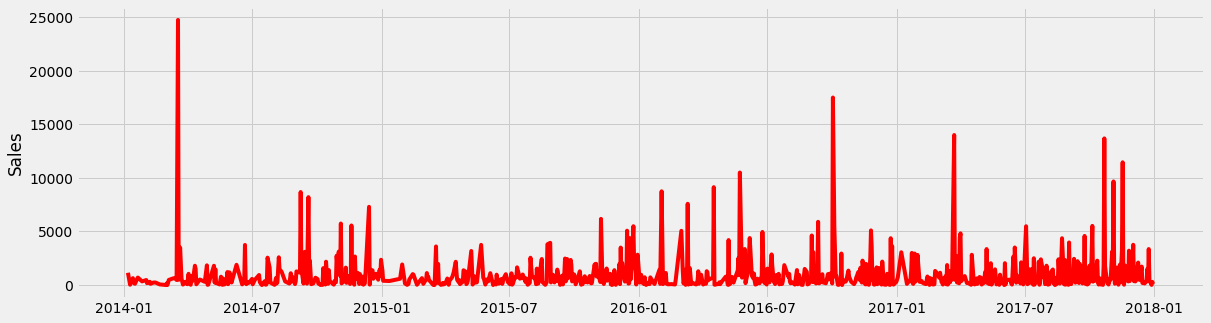

In [27]:
plt.figure(figsize = (18,5))
plt.plot(tech, c = 'r')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

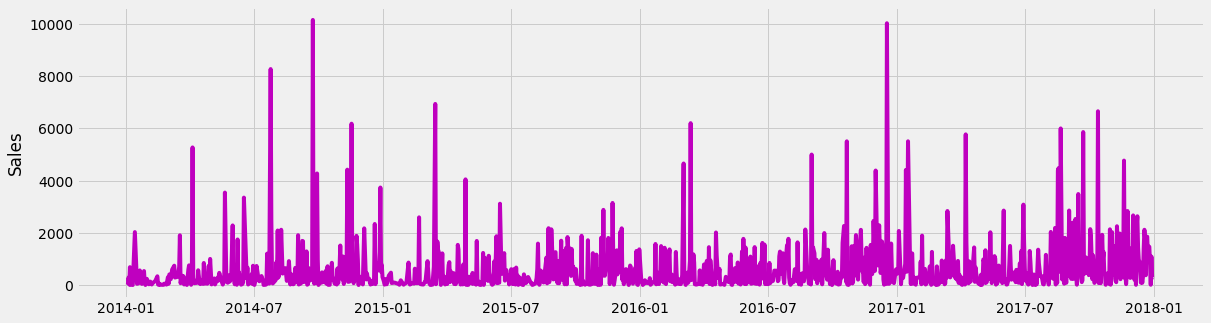

In [28]:
plt.figure(figsize = (18,5))
plt.plot(off_sup , c= 'm')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

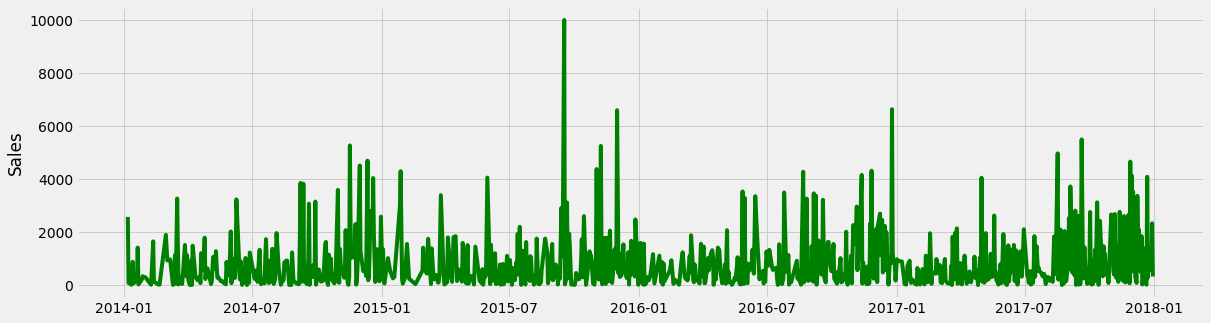

In [29]:
plt.figure(figsize = (18,5))
plt.plot(furniture, c = 'g')
plt.ylabel('Sales')

Plotting the mean sales data for each categories

Text(0.5, 1.0, 'TECHNOLOGY SALES')

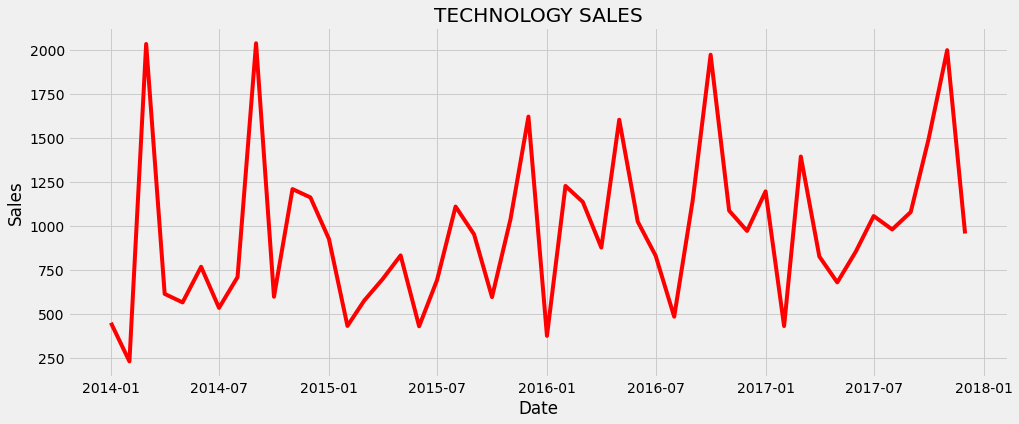

In [30]:
plt.figure(figsize = (15,6))
plt.plot(tech_y, c = 'r')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('TECHNOLOGY SALES')

Text(0.5, 1.0, 'OFFICE SUPPLY SALES')

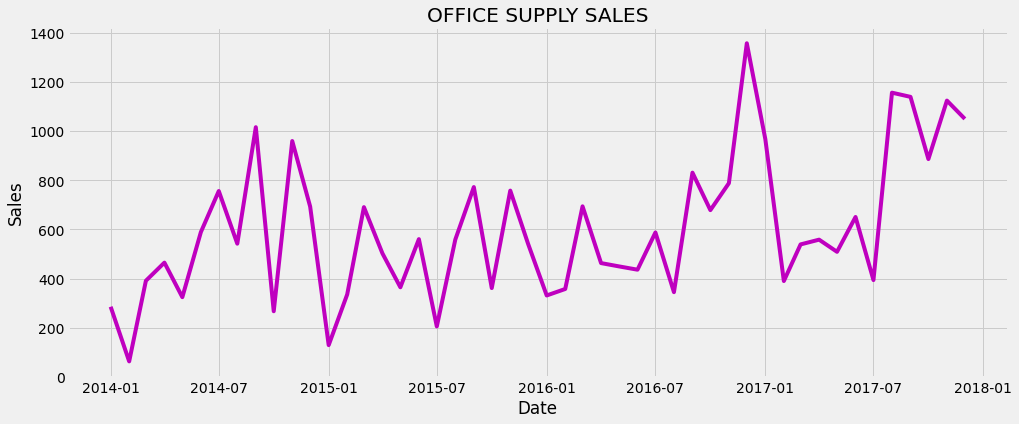

In [31]:
plt.figure(figsize = (15,6))
plt.plot(office_y, c = 'm')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('OFFICE SUPPLY SALES')

Text(0.5, 1.0, 'FURNITURE SALES')

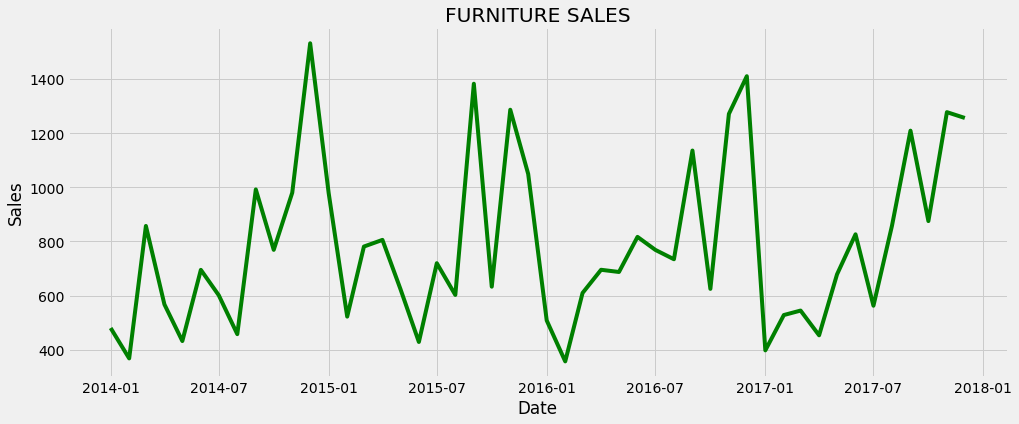

In [32]:
plt.figure(figsize = (15,6))
plt.plot(furniture_y, c = 'g')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('FURNITURE SALES')

Boxplots on sales of each product categories

Text(0.5, 1.0, 'Technology Sales')

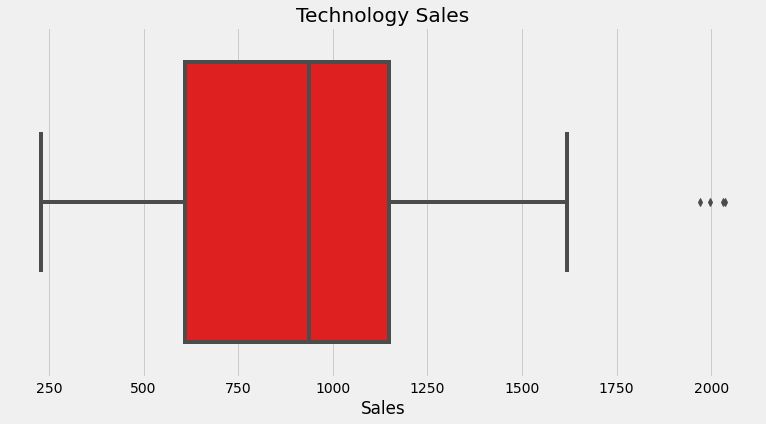

In [33]:
plt.figure(figsize = (12,6))
sns.boxplot(tech_y, color = 'r').set_title('Technology Sales')

Text(0.5, 1.0, 'Office Supplies Sales')

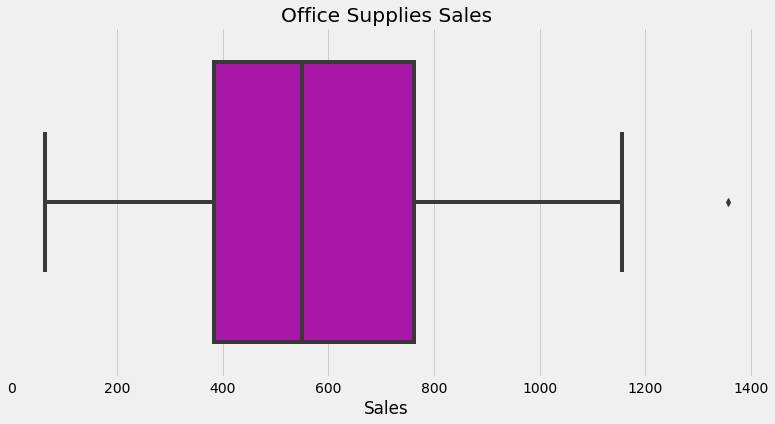

In [34]:
plt.figure(figsize = (12,6))
sns.boxplot(office_y, color = 'm').set_title('Office Supplies Sales')

Text(0.5, 1.0, 'Furniture Sales')

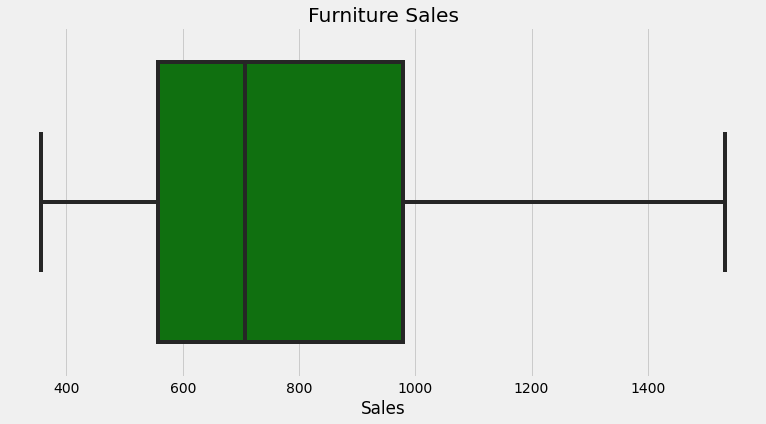

In [35]:
plt.figure(figsize = (12,6))
sns.boxplot(furniture_y, color = 'g').set_title('Furniture Sales')

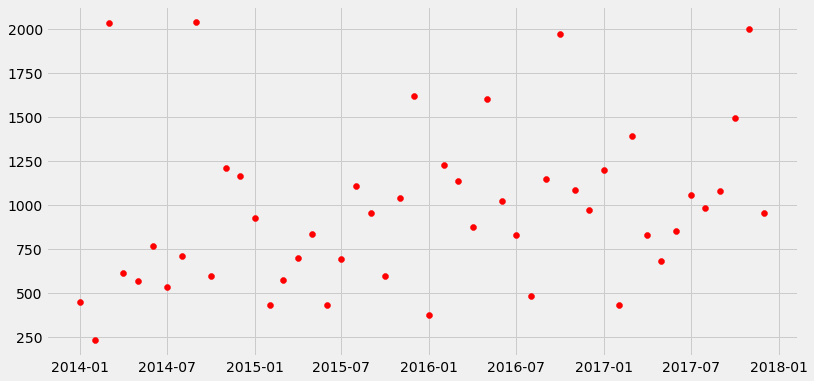

In [36]:
plt.figure(figsize = (12,6))
plt.scatter(tech_y.index,tech_y, c = 'r')

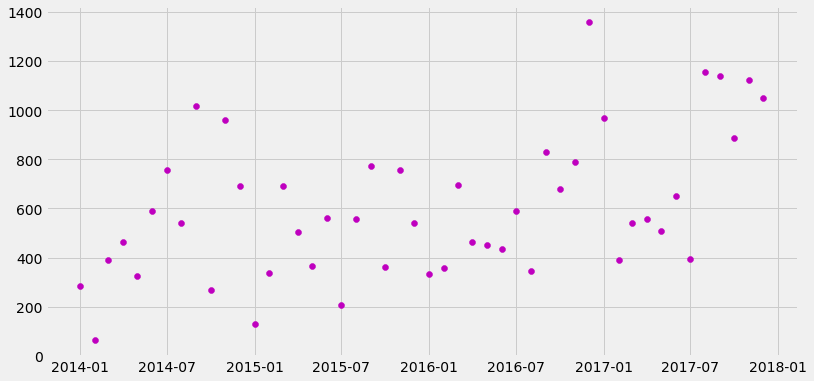

In [37]:
plt.figure(figsize = (12,6))
plt.scatter(office_y.index,office_y, c = 'm')

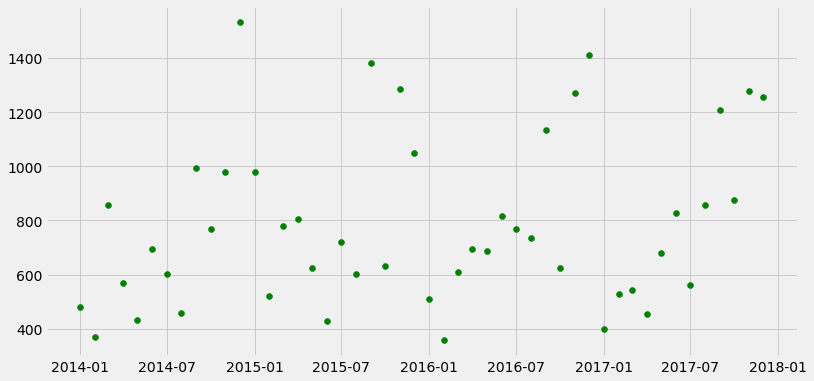

In [38]:
plt.figure(figsize = (12,6))
plt.scatter(furniture_y.index,furniture_y, c = 'g')

Performing ETS Decomposition

ETS Decomposition for Technology Category

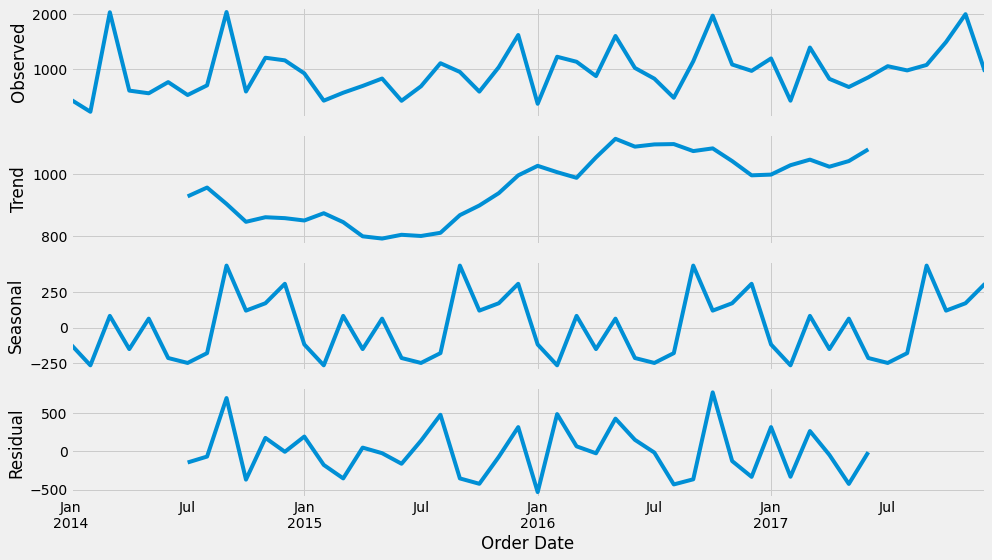

In [39]:
from pylab import rcParams
rcParams['figure.figsize']=14,8
tech_decomp = sm.tsa.seasonal_decompose(tech_y, model = 'additive')
fig = tech_decomp.plot()
plt.show()

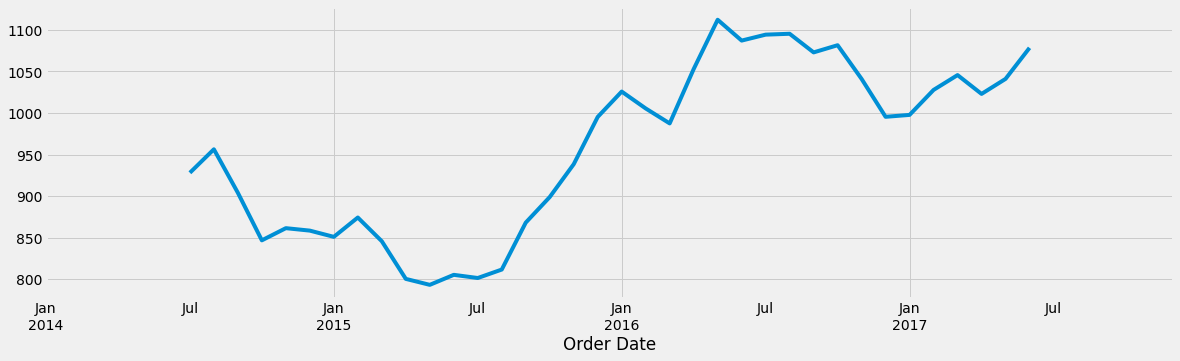

In [40]:
tech_decomp.trend.plot(figsize=(18,5))

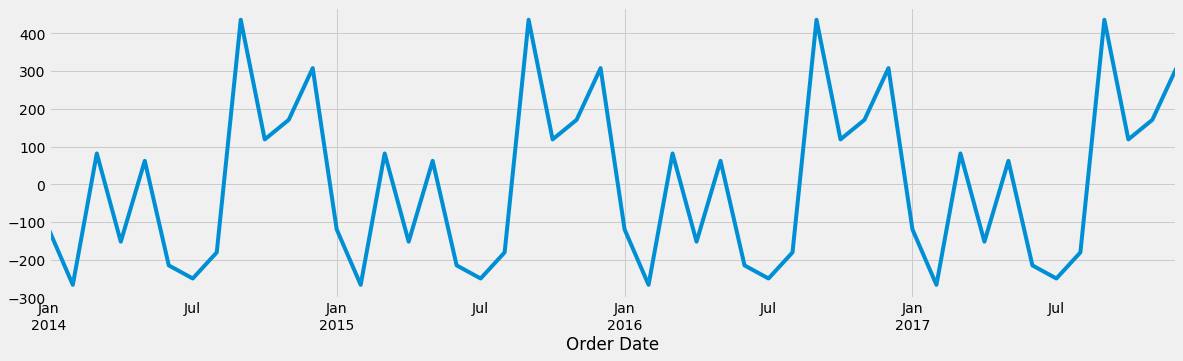

In [41]:
tech_decomp.seasonal.plot(figsize=(18,5))

ETS Decomposition for Office Supplies Category

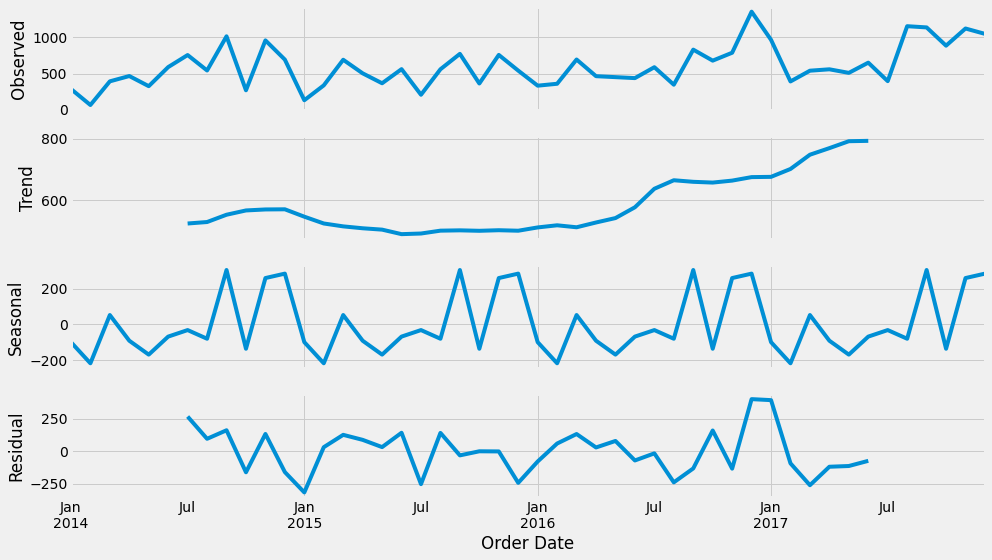

In [42]:
from pylab import rcParams
rcParams['figure.figsize']=14,8
office_decomp = sm.tsa.seasonal_decompose(office_y, model = 'additive')
fig = office_decomp.plot()
plt.show()

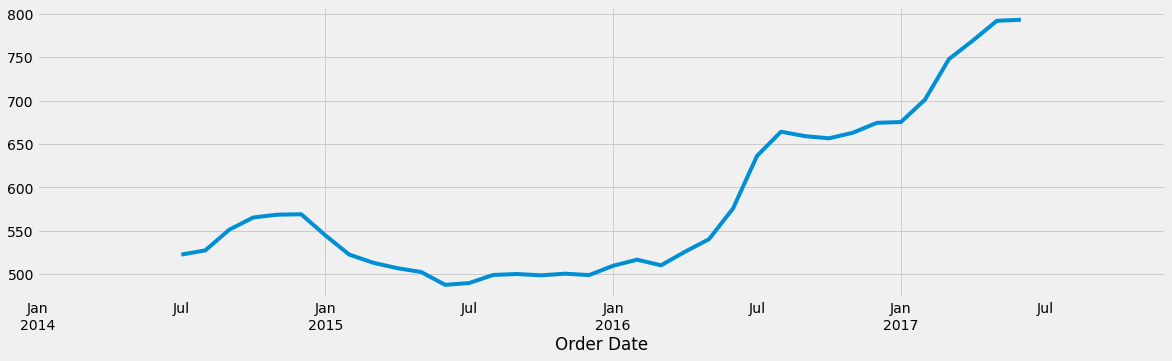

In [43]:
office_decomp.trend.plot(figsize=(18,5))

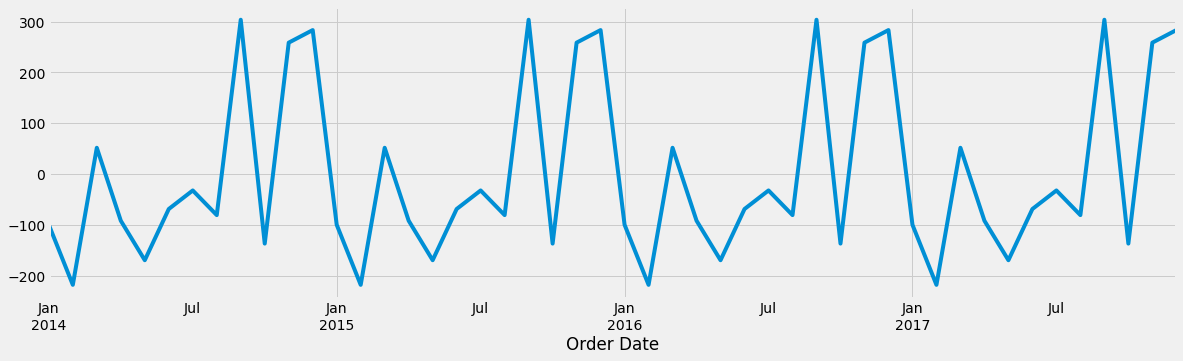

In [44]:
office_decomp.seasonal.plot(figsize = (18,5))

ETS Decomposition for Furniture Category

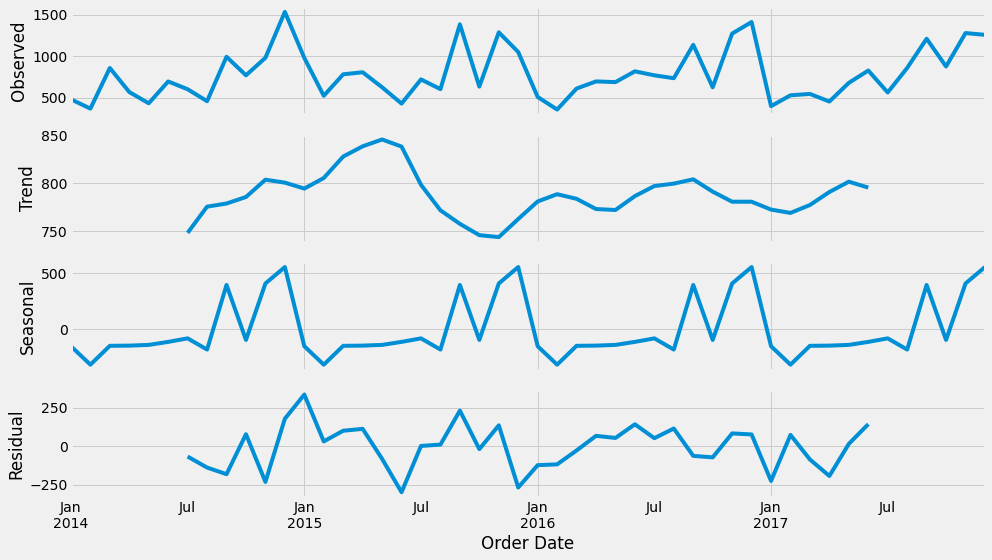

In [45]:
from pylab import rcParams
rcParams['figure.figsize']=14,8
furniture_decomp = sm.tsa.seasonal_decompose(furniture_y, model = 'additive')
fig = furniture_decomp.plot()
plt.show()

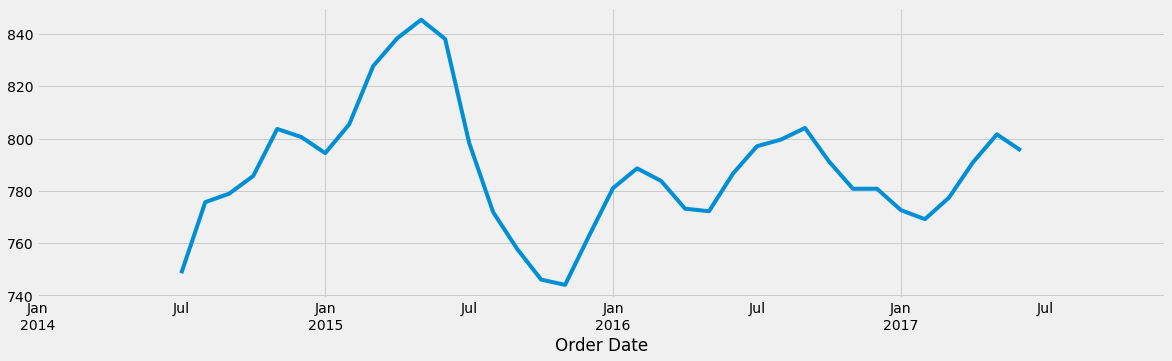

In [46]:
furniture_decomp.trend.plot(figsize=(18,5))

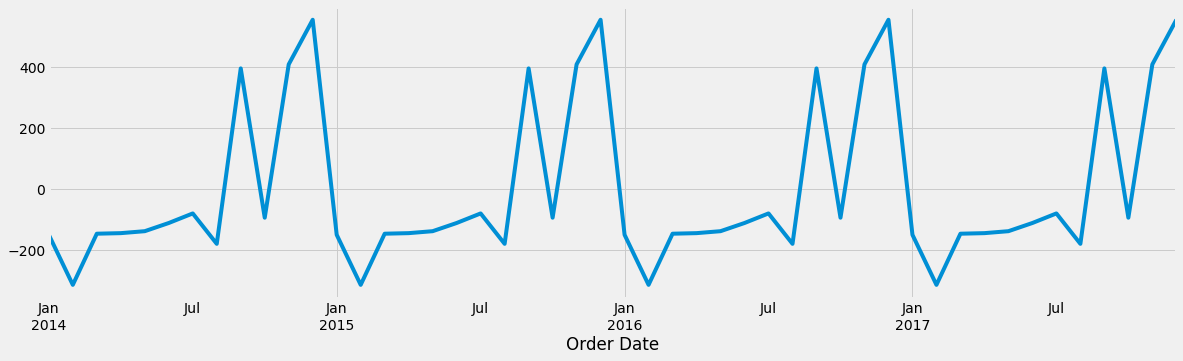

In [47]:
furniture_decomp.seasonal.plot(figsize = (18,5))

Test for Stationarity

In [48]:
from statsmodels.tsa.stattools import adfuller
def stationary_test(time_series, title = ' '):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(time_series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for k,v in result[4].items():
        out[f'critical value ({k})']=v
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

Augmented Dickey-Fuller test for Technology Category

In [49]:
stationary_test(tech_y)

Augmented Dickey-Fuller Test:  
ADF test statistic     -7.187969e+00
p-value                 2.547334e-10
# lags used             0.000000e+00
# observations          4.700000e+01
critical value (1%)    -3.577848e+00
critical value (5%)    -2.925338e+00
critical value (10%)   -2.600774e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller test for Office Supplies Category

In [50]:
stationary_test(office_y)

Augmented Dickey-Fuller Test:  
ADF test statistic      -4.664633
p-value                  0.000098
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller test for Furniture Category

In [51]:
stationary_test(furniture_y)

Augmented Dickey-Fuller Test:  
ADF test statistic      -5.191070
p-value                  0.000009
# lags used             10.000000
# observations          37.000000
critical value (1%)     -3.620918
critical value (5%)     -2.943539
critical value (10%)    -2.610400
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Time series forecasting with SARIMA

Technology Category

Dividing the training and test data by 70-30

In [52]:
tech_train = tech_y.iloc[:34]
tech_test = tech_y.iloc[34:]

In [53]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 42.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


Finding the best model using auto_arima library

In [54]:
from pmdarima import auto_arima

In [55]:
model_tech = auto_arima(tech_y,m=10,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[10] intercept   : AIC=732.546, Time=1.55 sec
 ARIMA(0,0,0)(0,0,0)[10] intercept   : AIC=725.877, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[10] intercept   : AIC=729.509, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[10] intercept   : AIC=729.015, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[10]             : AIC=807.454, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[10] intercept   : AIC=727.769, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[10] intercept   : AIC=727.111, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[10] intercept   : AIC=729.109, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[10] intercept   : AIC=727.740, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[10] intercept   : AIC=727.697, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[10] intercept   : AIC=729.641, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[10] intercept
Total fit time: 2.267 seconds


In [56]:
model_tech.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                        SARIMAX   Log Likelihood                -360.939
Date:                Thu, 26 May 2022   AIC                            725.877
Time:                        16:45:49   BIC                            729.620
Sample:                             0   HQIC                           727.291
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    967.6149     77.667     12.458      0.000     815.390    1119.840
sigma2       1.99e+05   4.64e+04      4.292      0.000    1.08e+05     2.9e+05
===================================================================================
Ljung-Box (Q):                       38.00   Jarque-Bera (JB):                 5.70
Prob(Q):                              0.56   Prob(JB):                         0.06
Heteroskedasticity (H):               0.69   Skew:                             0.84
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
model_tech

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 10),
      suppress_warnings=True)

Training of the model

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [59]:
model_tech = SARIMAX(tech_train,order=(0, 0, 0),seasonal_order=(0, 0, 0, 10),enforce_invertibility=False)

In [60]:
result_tech = model_tech.fit()

In [61]:
result_tech.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   34
Model:                        SARIMAX   Log Likelihood                -284.354
Date:                Thu, 26 May 2022   AIC                            570.709
Time:                        16:45:49   BIC                            572.235
Sample:                    01-01-2014   HQIC                           571.229
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.076e+06   3.58e+05      3.003      0.003    3.74e+05    1.78e+06
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 5.30
Prob(Q):                               nan   Prob(JB):                         0.07
Heteroskedasticity (H):               1.29   Skew:                             0.96
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plotting characteristics of the model to find unusual behaviour

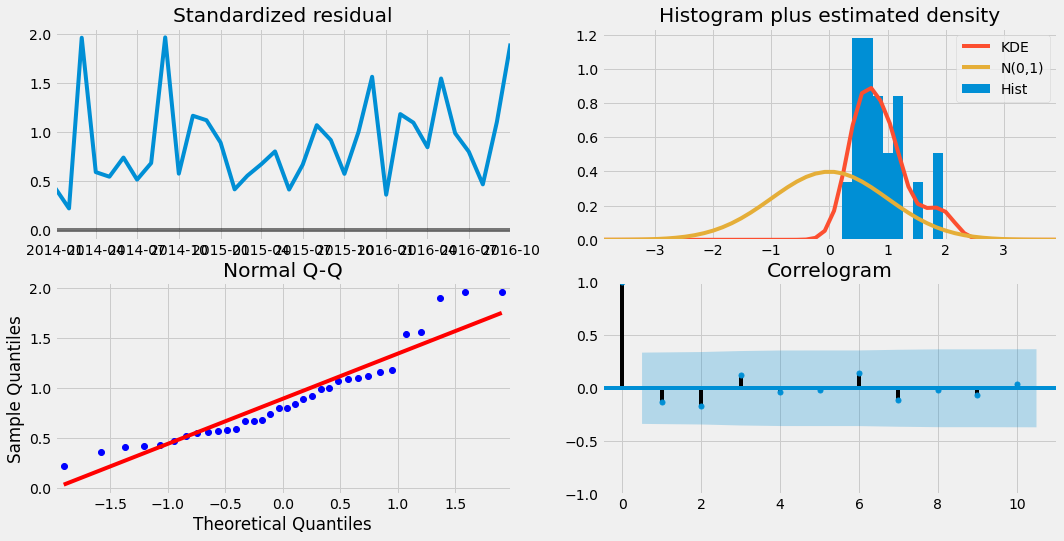

In [62]:
result_tech.plot_diagnostics(figsize=(16,8))
plt.show()

Prediction of values in the future

In [63]:
start = len(tech_train)
end = len(tech_train) + len(tech_test) - 1

In [64]:
prediction_tech = result_tech.predict(start,end).rename('SARIMA model')
prediction_tech

2016-11-01    0.0
2016-12-01    0.0
2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
2017-05-01    0.0
2017-06-01    0.0
2017-07-01    0.0
2017-08-01    0.0
2017-09-01    0.0
2017-10-01    0.0
2017-11-01    0.0
2017-12-01    0.0
Freq: MS, Name: SARIMA model, dtype: float64

Evaluating the model performance

In [65]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [66]:
mean_squared_error(tech_test,prediction_tech)

1279111.6376727268

In [67]:
rmse(tech_test,prediction_tech)

1130.978177363616

In [68]:
tech_test.mean()

1070.6656205540319

Now let us forecast into the unknown future

In [69]:
model_tech_final = SARIMAX(tech_y,order=(0, 0, 0),seasonal_order=(0, 0, 0, 19),enforce_invertibility=False)
result_tech_final = model_tech_final.fit()

In [70]:
forecast_tech = result_tech_final.predict(len(tech_y),len(tech_y)+13,typ='levels').rename('SARIMA forecast')

Text(0.5, 1.0, 'Technology sales')

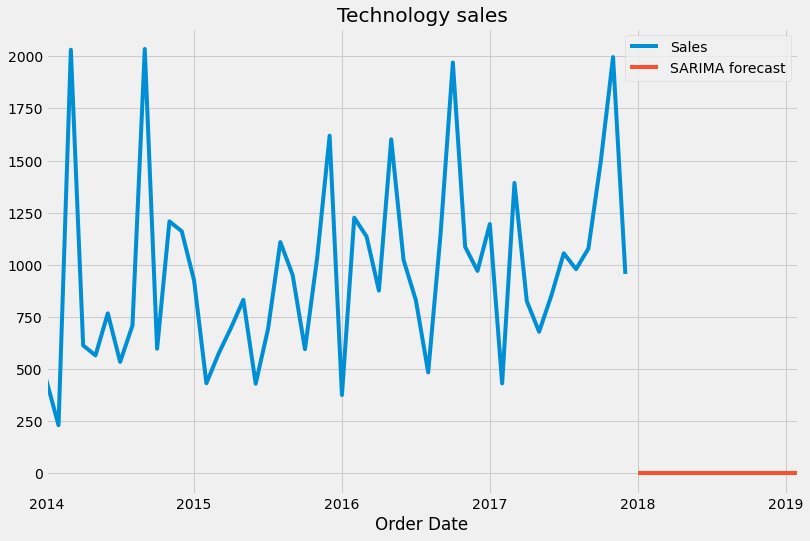

In [71]:
tech_y.plot(legend=True,figsize=(12,8))
forecast_tech.plot(legend=True)
plt.title("Technology sales")

Office Supplies Category

In [72]:
office_train = office_y.iloc[:34]
office_test = office_y.iloc[34:]

Finding the best model using auto_arima library

In [73]:
model_office = auto_arima(office_y,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=667.416, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=682.234, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=672.340, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=680.349, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=668.517, Time=0.69 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=668.755, Time=0.29 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=664.491, Time=2.43 sec
 A

In [74]:
model_office.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -325.246
Date:                            Thu, 26 May 2022   AIC                            664.491
Time:                                    16:46:30   BIC                            677.442
Sample:                                         0   HQIC                           669.365
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1149      5.086      0.023      0.982      -9.853      10.083
ar.L1          0.1726      0.238      0.725      0.468      -0.294       0.639
ar.L2          0.0802      0.237      0.339      0.735      -0.384       0.544
ma.L1         -0.9795      0.328     -2.986      0.003      -1.622      -0.337
ar.S.L12       0.9823      0.784      1.252      0.210      -0.555       2.519
ma.S.L12      -0.8786      2.690     -0.327      0.744      -6.151       4.394
sigma2      5.943e+04   9.94e+04      0.598      0.550   -1.35e+05    2.54e+05
===================================================================================
Ljung-Box (Q):                       30.63   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.86   Prob(JB):                         0.33
Heteroskedasticity (H):               1.20   Skew:                             0.51
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Training of the model

In [77]:
model_office = SARIMAX(office_train,order=(0, 1, 0),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
result_office = model_office.fit()
result_office.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   34
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -237.583
Date:                Thu, 26 May 2022   AIC                            477.166
Time:                        16:47:03   BIC                            478.663
Sample:                    01-01-2014   HQIC                           477.670
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.048e+05   2.97e+04      3.526      0.000    4.66e+04    1.63e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.37
Prob(Q):                               nan   Prob(JB):                         0.83
Heteroskedasticity (H):               0.36   Skew:                            -0.10
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plotting characteristics of the model to find unusual behaviour

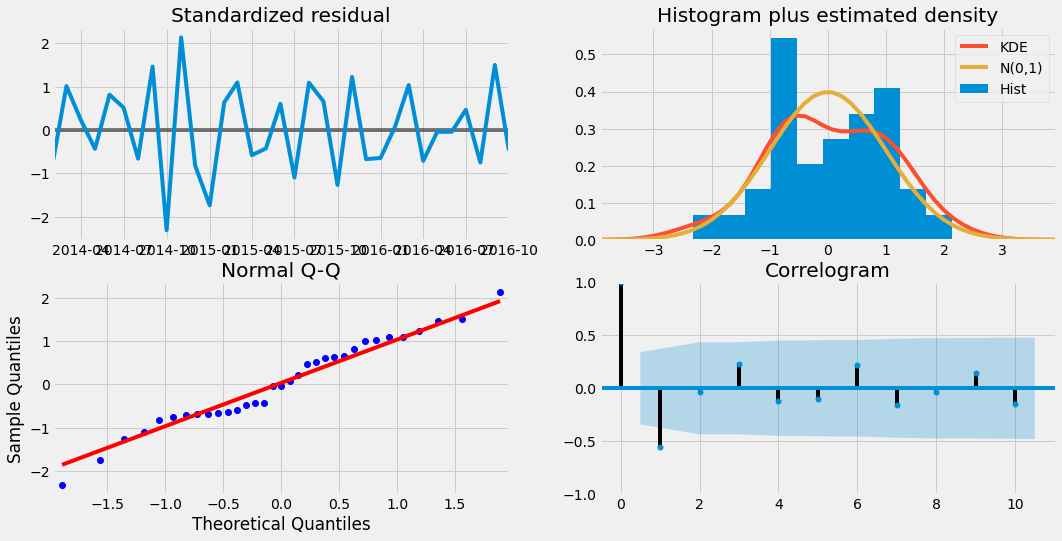

In [78]:
result_office.plot_diagnostics(figsize=(16,8))
plt.show()

Prediction of values in the future

In [79]:
start = len(office_train)
end = len(office_train) + len(office_test) - 1

In [80]:
prediction_office = result_office.predict(start,end).rename('SARIMA model predictions')
prediction_office

2016-11-01    678.408083
2016-12-01    678.408083
2017-01-01    678.408083
2017-02-01    678.408083
2017-03-01    678.408083
2017-04-01    678.408083
2017-05-01    678.408083
2017-06-01    678.408083
2017-07-01    678.408083
2017-08-01    678.408083
2017-09-01    678.408083
2017-10-01    678.408083
2017-11-01    678.408083
2017-12-01    678.408083
Freq: MS, Name: SARIMA model predictions, dtype: float64

Text(0.5, 1.0, 'Office Supplies sales')

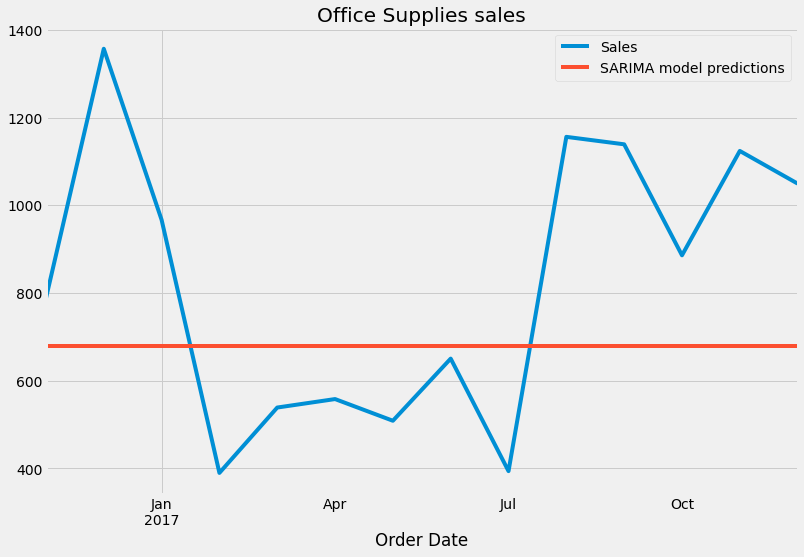

In [81]:
office_test.plot(figsize=(12,8),legend=True)
prediction_office.plot(legend=True)
plt.title("Office Supplies sales")

Evaluating the model performance

In [82]:
mean_squared_error(office_test,prediction_office)

114531.50739221273

In [83]:
rmse(office_test,prediction_office)

338.4250395467403

In [84]:
office_test.mean()

821.934851319071

Now let us forecast into the unknown future

In [85]:
model_office_final = SARIMAX(office_y,order=(1, 1, 1),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
result_office_final = model_office_final.fit()

In [86]:
forecast_office = result_office_final.predict(len(office_y),len(office_y)+13,typ='levels').rename('SARIMA forecast')

Text(0.5, 1.0, 'Office Supplies sales')

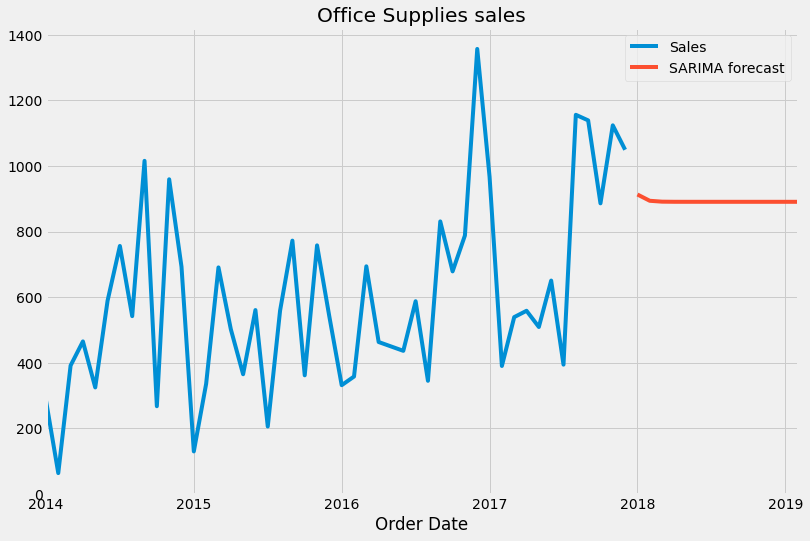

In [87]:
office_y.plot(legend=True,figsize=(12,8))
forecast_office.plot(legend=True)
plt.title("Office Supplies sales")

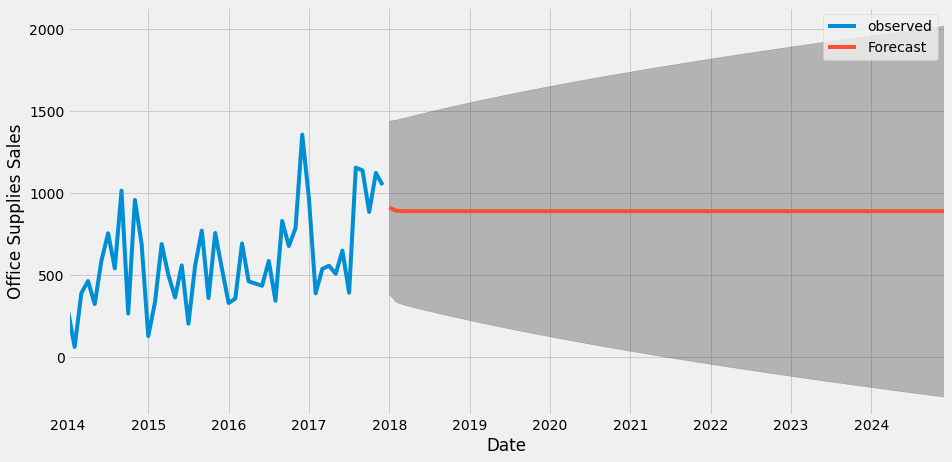

In [88]:
pred_office = result_office_final.get_forecast(steps=84)
pred_ci_office = pred_office.conf_int()
ax = office_y.plot(label='observed',figsize=(14,7))
pred_office.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_office.index,
               pred_ci_office.iloc[:,0],
               pred_ci_office.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()


Furniture Category

In [89]:
furniture_train = furniture_y.iloc[:34]
furniture_test = furniture_y.iloc[34:]

In [90]:
model_furniture = auto_arima(furniture_y,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=497.083, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=494.685, Time=0.86 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=495.371, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=498.718, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=494.603, Time=1.87 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=492.715, Time=0.95 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=492.740, Time=0.17 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=494.612, Time=1.19 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=2.14 sec
 

In [91]:
model_furniture.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -243.627
Date:                  Thu, 26 May 2022   AIC                            491.254
Time:                          16:47:27   BIC                            494.421
Sample:                               0   HQIC                           492.359
                                   - 48                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4681      0.149     -3.132      0.002      -0.761      -0.175
sigma2      4.038e+04   1.22e+04      3.303      0.001    1.64e+04    6.43e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.75
Prob(Q):                               nan   Prob(JB):                         0.69
Heteroskedasticity (H):               0.50   Skew:                            -0.21
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
model_furniture = SARIMAX(furniture_train,order=(0, 0, 0),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
result_furniture = model_furniture.fit()
result_furniture.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   34
Model:                        SARIMAX   Log Likelihood                -275.516
Date:                Thu, 26 May 2022   AIC                            553.032
Time:                        16:47:49   BIC                            554.559
Sample:                    01-01-2014   HQIC                           553.553
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.398e+05   2.77e+05      2.307      0.021    9.63e+04    1.18e+06
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 6.21
Prob(Q):                               nan   Prob(JB):                         0.04
Heteroskedasticity (H):               1.21   Skew:                             1.00
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

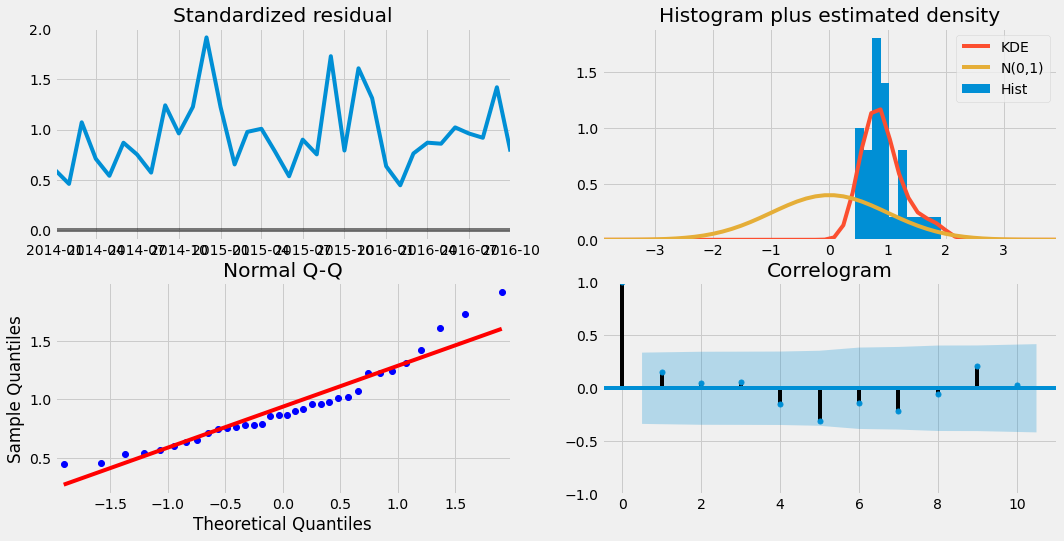

In [96]:
result_furniture.plot_diagnostics(figsize=(16,8))
plt.show()

Prediction of values in the future

In [97]:
start = len(furniture_train)
end = len(furniture_train) + len(furniture_test) - 1

In [98]:
prediction_furniture = result_furniture.predict(start,end).rename('SARIMA model predictions')
prediction_furniture

2016-11-01    0.0
2016-12-01    0.0
2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
2017-05-01    0.0
2017-06-01    0.0
2017-07-01    0.0
2017-08-01    0.0
2017-09-01    0.0
2017-10-01    0.0
2017-11-01    0.0
2017-12-01    0.0
Freq: MS, Name: SARIMA model predictions, dtype: float64

Text(0.5, 1.0, 'Furniture sales')

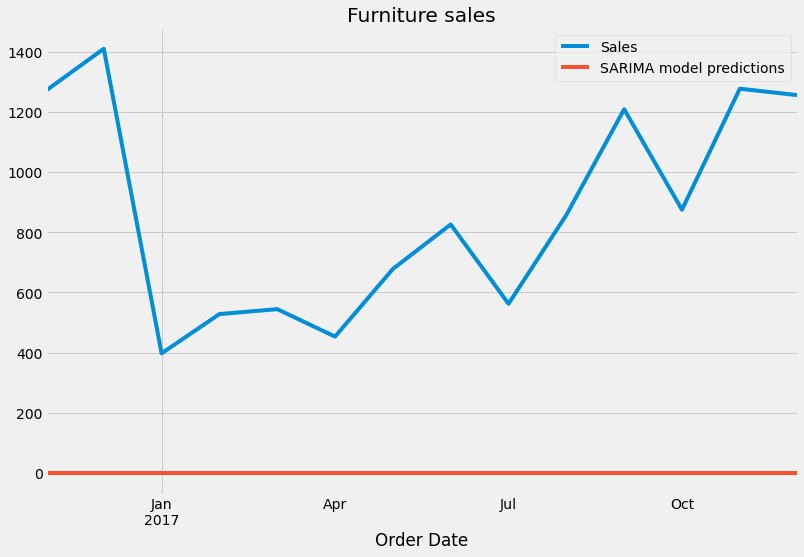

In [99]:
furniture_test.plot(figsize=(12,8),legend=True)
prediction_furniture.plot(legend=True)
plt.title("Furniture sales")

Evaluating the model performance

In [100]:
mean_squared_error(furniture_test,prediction_furniture)

870104.1983069152

In [101]:
rmse(furniture_test,prediction_furniture)

932.7937597920106

In [102]:
furniture_test.mean()

867.8552960939827

Now let us forecast into the unknown future

In [105]:
model_furniture_final = SARIMAX(furniture_y,order=(1, 0, 1),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
result_furniture_final = model_furniture_final.fit()

In [106]:
forecast_furniture = result_furniture_final.predict(len(furniture_y),len(furniture_y)+13,typ='levels').rename('SARIMA forecast')

Text(0.5, 1.0, 'Furniture sales')

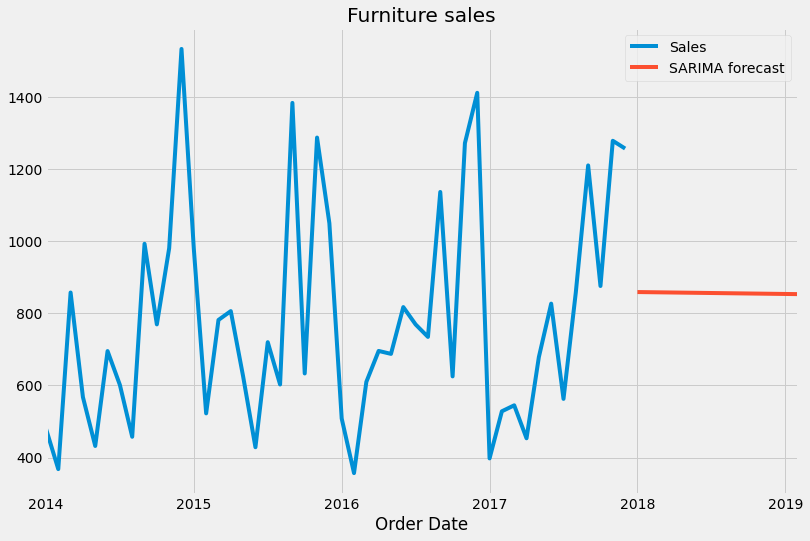

In [107]:
furniture_y.plot(legend=True,figsize=(12,8))
forecast_furniture.plot(legend=True)
plt.title("Furniture sales")

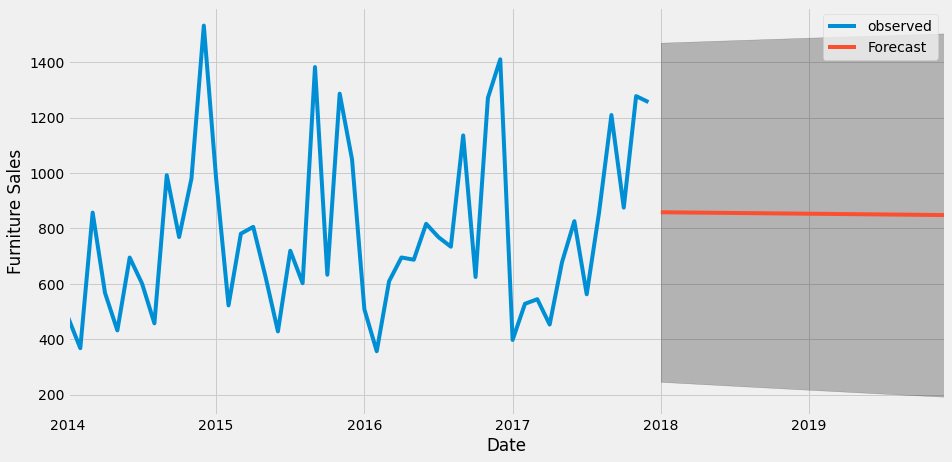

In [108]:
pred_furniture = result_furniture_final.get_forecast(steps=24)
pred_ci_furniture = pred_furniture.conf_int()
ax = furniture_y.plot(label='observed',figsize=(14,7))
pred_furniture.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_furniture.index,
               pred_ci_furniture.iloc[:,0],
               pred_ci_furniture.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Exploring the data further and comparisions with other categories

Creating a dataframe out of each product categories that contains the monthly sales data

In [109]:
tech1 = pd.DataFrame({'Order Date': tech_y.index , 'Sales':tech_y.values})
office1 = pd.DataFrame({'Order Date': office_y.index , 'Sales':office_y.values})
furniture1 = pd.DataFrame({'Order Date': furniture_y.index , 'Sales':furniture_y.values})

Creating dataframes by merging the existing dataframes

In [110]:
store_office_technology = tech1.merge(office1, how='inner', on='Order Date')

In [111]:
store_office_technology.rename(columns={'Sales_x':'technology_sales','Sales_y':'office_sales'},inplace=True)
store_office_technology

,Order Date,technology_sales,office_sales
0,2014-01-01,449.041429,285.357647
1,2014-02-01,229.787143,63.042588
2,2014-03-01,2031.948375,391.176318
3,2014-04-01,613.028933,464.794750
4,2014-05-01,564.698588,324.346545
5,2014-06-01,766.905909,588.774409
6,2014-07-01,533.608933,756.060400
7,2014-08-01,708.435385,541.879143
8,2014-09-01,2035.838133,1015.677704
9,2014-10-01,596.900900,267.078815


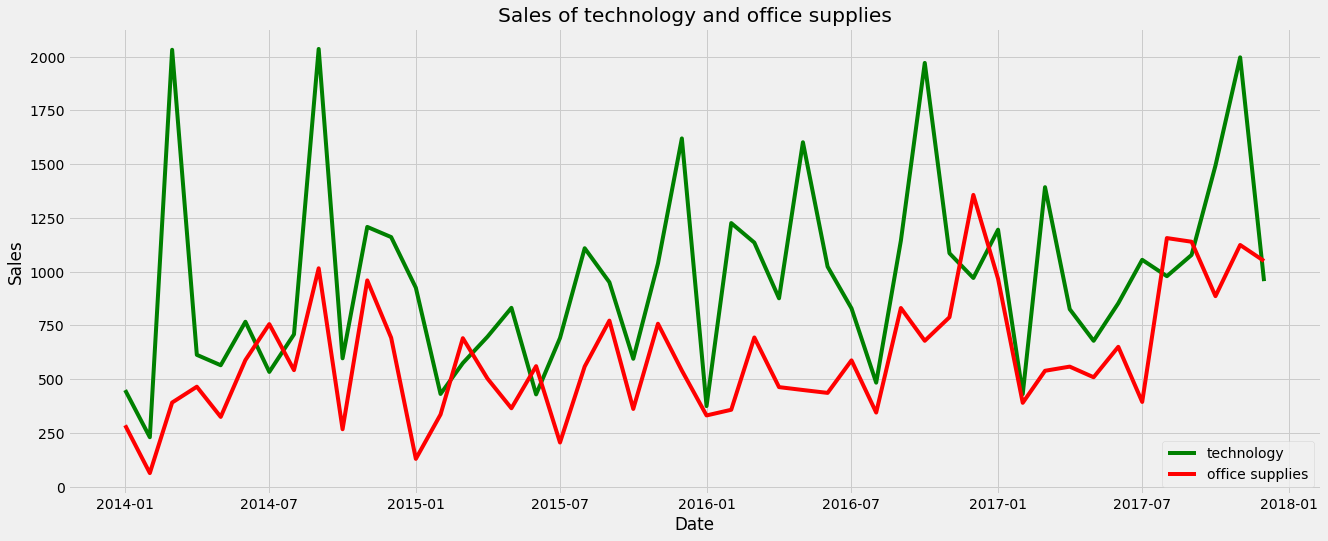

In [112]:
plt.figure(figsize=(20,8))
plt.plot(store_office_technology['Order Date'],store_office_technology['technology_sales'],'g-',label='technology')
plt.plot(store_office_technology['Order Date'],store_office_technology['office_sales'],'r-',label='office supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of technology and office supplies')
plt.legend()

In [113]:
store_office_furniture = furniture1.merge(office1, how='inner', on='Order Date')

In [114]:
store_office_furniture.rename(columns={'Sales_x':'furniture_sales','Sales_y':'office_sales'},inplace=True)

In [115]:
store_office_furniture

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545
5,2014-06-01,695.059242,588.774409
6,2014-07-01,601.169500,756.060400
7,2014-08-01,457.521656,541.879143
8,2014-09-01,992.353367,1015.677704
9,2014-10-01,769.015437,267.078815


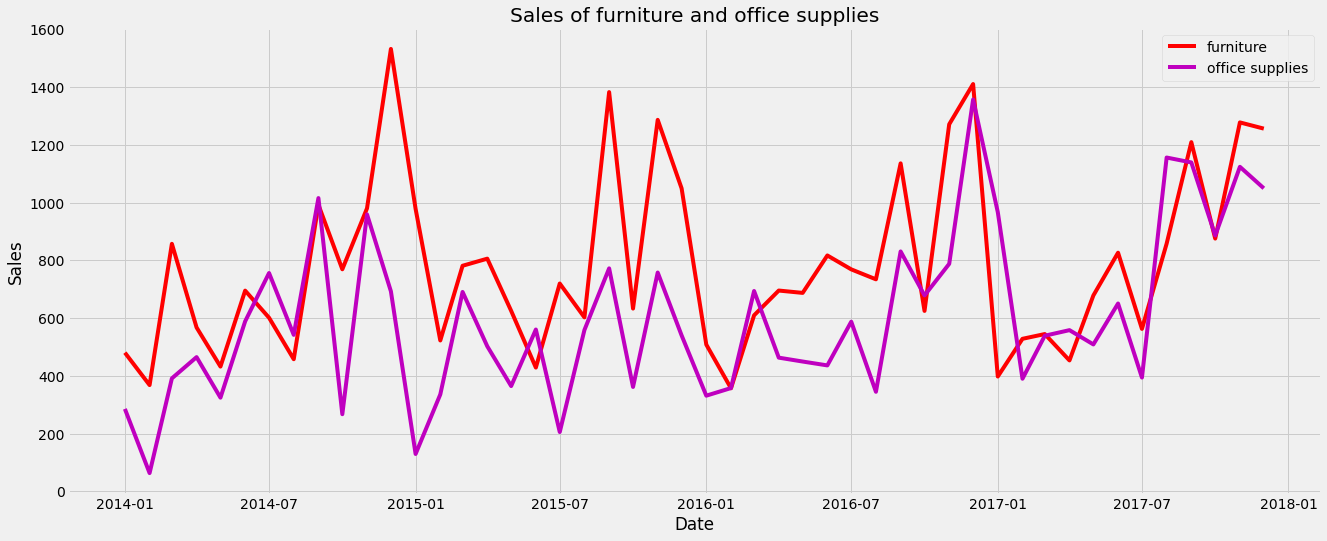

In [116]:
plt.figure(figsize=(20,8))
plt.plot(store_office_furniture['Order Date'],store_office_furniture['furniture_sales'],'r-',label='furniture')
plt.plot(store_office_furniture['Order Date'],store_office_furniture['office_sales'],'m-',label='office supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of furniture and office supplies')
plt.legend()

In [117]:
store_technology_furniture = furniture1.merge(tech1, how='inner', on='Order Date')
store_technology_furniture.rename(columns={'Sales_x':'furniture_sales','Sales_y':'technology_sales'},inplace=True)
store_technology_furniture

,Order Date,furniture_sales,technology_sales
0,2014-01-01,480.194231,449.041429
1,2014-02-01,367.931600,229.787143
2,2014-03-01,857.291529,2031.948375
3,2014-04-01,567.488357,613.028933
4,2014-05-01,432.049188,564.698588
5,2014-06-01,695.059242,766.905909
6,2014-07-01,601.169500,533.608933
7,2014-08-01,457.521656,708.435385
8,2014-09-01,992.353367,2035.838133
9,2014-10-01,769.015437,596.900900


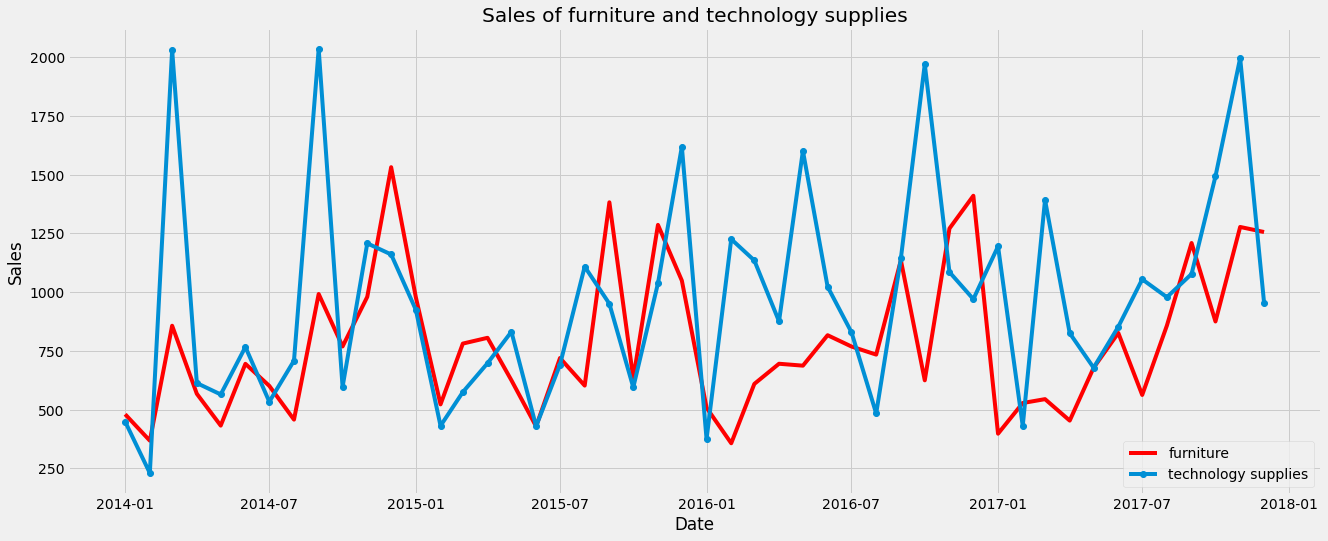

In [118]:
plt.figure(figsize=(20,8))
plt.plot(store_technology_furniture['Order Date'],store_technology_furniture['furniture_sales'],'r-',label='furniture')
plt.plot(store_technology_furniture['Order Date'],store_technology_furniture['technology_sales'],'o-',label='technology supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of furniture and technology supplies')
plt.legend()

In [119]:
store_office_furniture_technology = tech1.merge(store_office_furniture, how='inner', on='Order Date')
store_office_furniture_technology

,Order Date,Sales,furniture_sales,office_sales
0,2014-01-01,449.041429,480.194231,285.357647
1,2014-02-01,229.787143,367.931600,63.042588
2,2014-03-01,2031.948375,857.291529,391.176318
3,2014-04-01,613.028933,567.488357,464.794750
4,2014-05-01,564.698588,432.049188,324.346545
5,2014-06-01,766.905909,695.059242,588.774409
6,2014-07-01,533.608933,601.169500,756.060400
7,2014-08-01,708.435385,457.521656,541.879143
8,2014-09-01,2035.838133,992.353367,1015.677704
9,2014-10-01,596.900900,769.015437,267.078815


In [120]:
store_office_furniture_technology.rename(columns={'Sales':'technology_sales','Sales_x':'furniture_sales','Sales_y':'office_sales'},inplace=True)
store_office_furniture_technology

,Order Date,technology_sales,furniture_sales,office_sales
0,2014-01-01,449.041429,480.194231,285.357647
1,2014-02-01,229.787143,367.931600,63.042588
2,2014-03-01,2031.948375,857.291529,391.176318
3,2014-04-01,613.028933,567.488357,464.794750
4,2014-05-01,564.698588,432.049188,324.346545
5,2014-06-01,766.905909,695.059242,588.774409
6,2014-07-01,533.608933,601.169500,756.060400
7,2014-08-01,708.435385,457.521656,541.879143
8,2014-09-01,2035.838133,992.353367,1015.677704
9,2014-10-01,596.900900,769.015437,267.078815


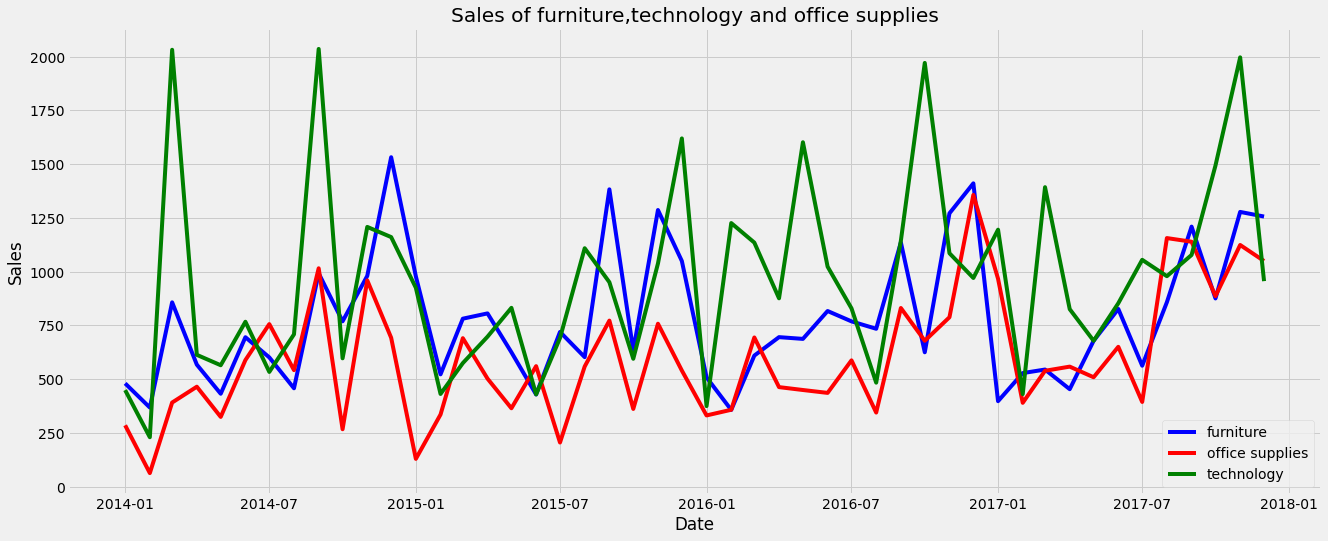

In [121]:
plt.figure(figsize=(20,8))
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['furniture_sales'],'b-',label='furniture')
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['office_sales'],'r-',label='office supplies')
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['technology_sales'],'g-',label='technology')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of furniture,technology and office supplies')
plt.legend()


Time series modelling with prophet

In [122]:
import pandas as pd
import fbprophet
from fbprophet import Prophet
import matplotlib.pyplot as plt

Technology category

In [123]:
tech_y_df = tech_y.to_frame()

In [124]:
tech_y_df['ds'] = tech_y_df.index

In [125]:
tech_y_df.columns = ['y','ds']

In [126]:
tech_y_df

,y,ds
Order Date,,
2014-01-01,449.041429,2014-01-01
2014-02-01,229.787143,2014-02-01
2014-03-01,2031.948375,2014-03-01
2014-04-01,613.028933,2014-04-01
2014-05-01,564.698588,2014-05-01
2014-06-01,766.905909,2014-06-01
2014-07-01,533.608933,2014-07-01
2014-08-01,708.435385,2014-08-01
2014-09-01,2035.838133,2014-09-01


In [127]:
tech_y_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       48 non-null     float64       
 1   ds      48 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [128]:
m_tech = Prophet()

In [129]:
m_tech.fit(tech_y_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
future_tech = m_tech.make_future_dataframe(periods=24,freq='MS')
future_tech

,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01
...,...
67,2019-08-01
68,2019-09-01
69,2019-10-01
70,2019-11-01


In [131]:
forecast_tech = m_tech.predict(future_tech)

In [132]:
forecast_tech

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,952.355848,400.234947,1089.602243,952.355848,952.355848,-220.575922,-220.575922,-220.575922,-220.575922,-220.575922,-220.575922,0.0,0.0,0.0,731.779926
1,2014-02-01,958.476983,-6.693091,700.588496,958.476983,958.476983,-613.862112,-613.862112,-613.862112,-613.862112,-613.862112,-613.862112,0.0,0.0,0.0,344.614871
2,2014-03-01,964.005750,770.827419,1488.427719,964.005750,964.005750,181.810553,181.810553,181.810553,181.810553,181.810553,181.810553,0.0,0.0,0.0,1145.816303
3,2014-04-01,970.126885,291.542358,1004.155000,970.126885,970.126885,-328.523260,-328.523260,-328.523260,-328.523260,-328.523260,-328.523260,0.0,0.0,0.0,641.603626
4,2014-05-01,976.050565,380.820477,1083.801005,976.050565,976.050565,-237.352937,-237.352937,-237.352937,-237.352937,-237.352937,-237.352937,0.0,0.0,0.0,738.697628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-08-01,1354.771259,1127.027082,1835.470959,1354.771212,1354.771305,135.984662,135.984662,135.984662,135.984662,135.984662,135.984662,0.0,0.0,0.0,1490.755922
68,2019-09-01,1360.892397,1364.657732,2114.081335,1360.892347,1360.892446,399.261873,399.261873,399.261873,399.261873,399.261873,399.261873,0.0,0.0,0.0,1760.154270
69,2019-10-01,1366.816079,443.698508,1144.950756,1366.816025,1366.816132,-585.314418,-585.314418,-585.314418,-585.314418,-585.314418,-585.314418,0.0,0.0,0.0,781.501661
70,2019-11-01,1372.937217,1162.971028,1889.638679,1372.937159,1372.937274,150.401115,150.401115,150.401115,150.401115,150.401115,150.401115,0.0,0.0,0.0,1523.338332


In [133]:
forecast_tech.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [134]:
forecast_tech[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

,ds,yhat_lower,yhat_upper,yhat
60,2019-01-01,506.333452,1228.940584,883.346452
61,2019-02-01,597.335697,1329.134742,955.920525
62,2019-03-01,1091.521750,1807.181963,1438.858819
63,2019-04-01,626.424791,1340.474804,991.798219
64,2019-05-01,612.790853,1322.029257,955.687693
65,2019-06-01,558.085696,1286.437882,924.219609
66,2019-07-01,731.602355,1435.606257,1083.824250
67,2019-08-01,1127.027082,1835.470959,1490.755922
68,2019-09-01,1364.657732,2114.081335,1760.154270
69,2019-10-01,443.698508,1144.950756,781.501661


Text(14.850000000000001, 0.5, 'Sales')

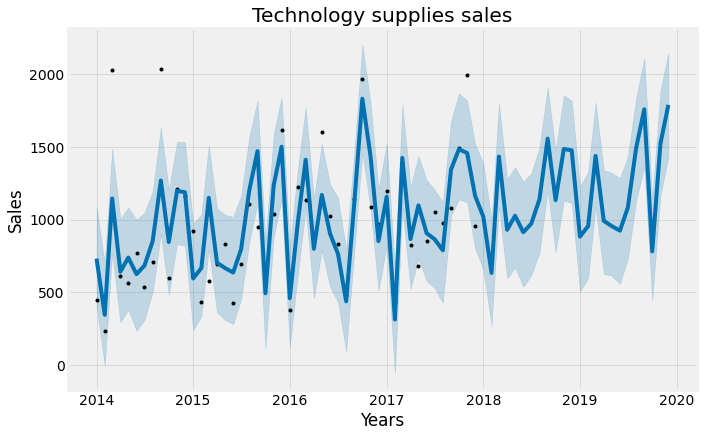

In [135]:
m_tech.plot(forecast_tech);
plt.title('Technology supplies sales')
plt.xlabel('Years')
plt.ylabel('Sales')

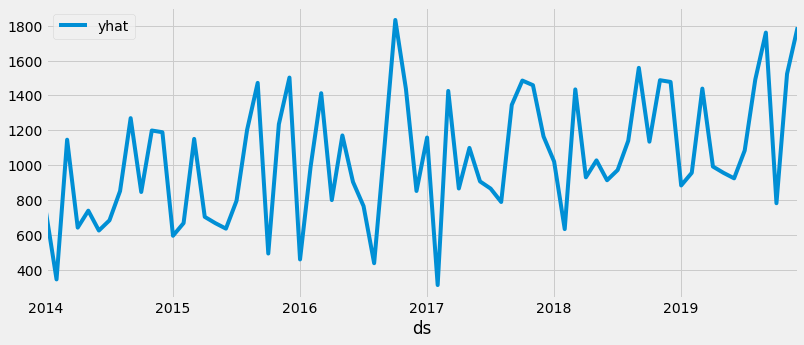

In [136]:
forecast_tech.plot(x='ds',y='yhat',figsize=(12,5))

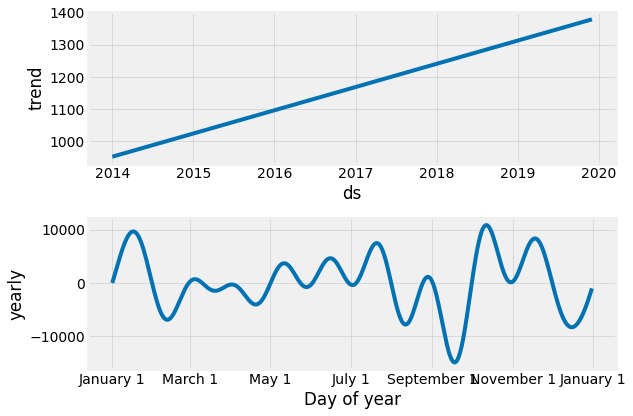

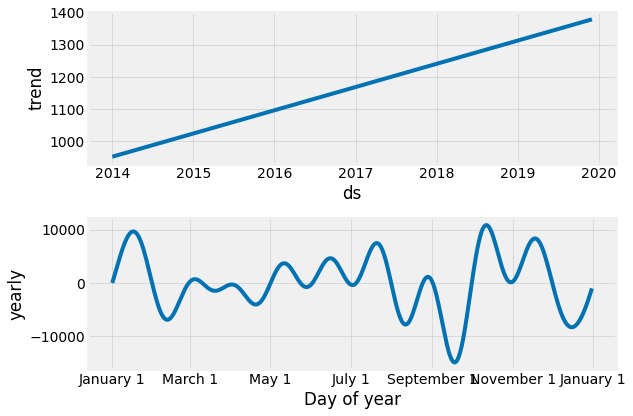

In [139]:
m_tech.plot_components(forecast_tech)

Office Supplies Category

In [140]:
office_y_df = office_y.to_frame()

In [141]:
office_y_df['ds'] = office_y_df.index

In [142]:
office_y_df.columns = ['y','ds']

In [143]:
office_y_df

,y,ds
Order Date,,
2014-01-01,285.357647,2014-01-01
2014-02-01,63.042588,2014-02-01
2014-03-01,391.176318,2014-03-01
2014-04-01,464.794750,2014-04-01
2014-05-01,324.346545,2014-05-01
2014-06-01,588.774409,2014-06-01
2014-07-01,756.060400,2014-07-01
2014-08-01,541.879143,2014-08-01
2014-09-01,1015.677704,2014-09-01


In [144]:
office_y_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       48 non-null     float64       
 1   ds      48 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [145]:
m_office = Prophet()

In [146]:
m_office.fit(office_y_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [147]:
future_office = m_office.make_future_dataframe(periods=24,freq='MS')

In [148]:
future_office

,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01
...,...
67,2019-08-01
68,2019-09-01
69,2019-10-01
70,2019-11-01


In [149]:
forecast_office = m_office.predict(future_office)

In [150]:
forecast_office

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,487.530759,149.513019,550.195355,487.530759,487.530759,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,494.918445,-90.077650,311.194535,494.918445,494.918445,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,501.591193,260.320629,667.918567,501.591193,501.591193,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,508.978878,178.291541,576.471445,508.978878,508.978878,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,516.128251,49.868998,443.978586,516.128251,516.128251,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-08-01,973.646513,817.608724,1228.332944,973.620149,973.675764,43.876319,43.876319,43.876319,43.876319,43.876319,43.876319,0.0,0.0,0.0,1017.522832
68,2019-09-01,981.044899,1125.438924,1503.796743,981.016240,981.076818,338.281914,338.281914,338.281914,338.281914,338.281914,338.281914,0.0,0.0,0.0,1319.326813
69,2019-10-01,988.204628,603.312349,986.834448,988.174090,988.238418,-188.232901,-188.232901,-188.232901,-188.232901,-188.232901,-188.232901,0.0,0.0,0.0,799.971727
70,2019-11-01,995.603015,1211.226907,1593.194889,995.570303,995.638962,400.624464,400.624464,400.624464,400.624464,400.624464,400.624464,0.0,0.0,0.0,1396.227478


In [151]:
forecast_office[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

,ds,yhat_lower,yhat_upper,yhat
60,2019-01-01,483.024014,875.660178,680.667168
61,2019-02-01,431.724252,830.296301,635.972532
62,2019-03-01,756.798030,1155.108368,946.732949
63,2019-04-01,633.679656,1015.402765,822.147677
64,2019-05-01,436.954196,830.053460,628.940592
65,2019-06-01,683.799594,1094.079364,884.346368
66,2019-07-01,482.363387,871.783672,677.208351
67,2019-08-01,817.608724,1228.332944,1017.522832
68,2019-09-01,1125.438924,1503.796743,1319.326813
69,2019-10-01,603.312349,986.834448,799.971727


Text(14.725000000000001, 0.5, 'Sales')

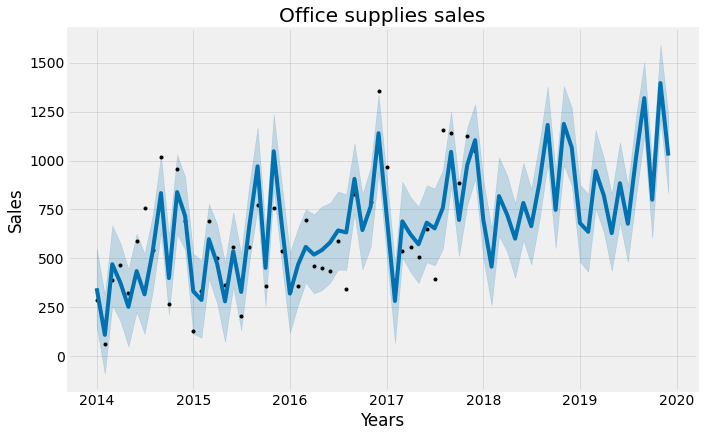

In [152]:
m_office.plot(forecast_office);
plt.title('Office supplies sales')
plt.xlabel('Years')
plt.ylabel('Sales')

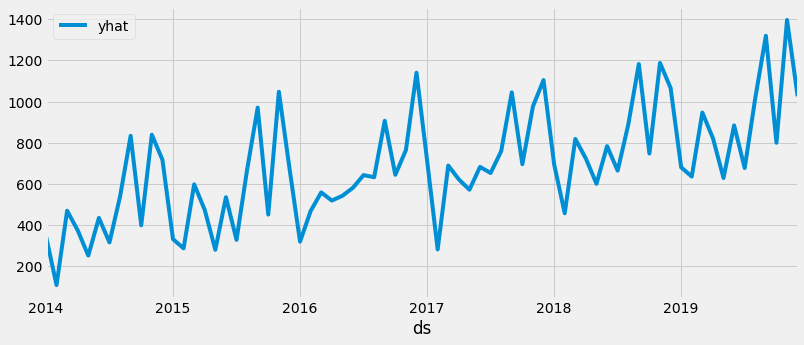

In [154]:
forecast_office.plot(x='ds',y='yhat',figsize=(12,5))

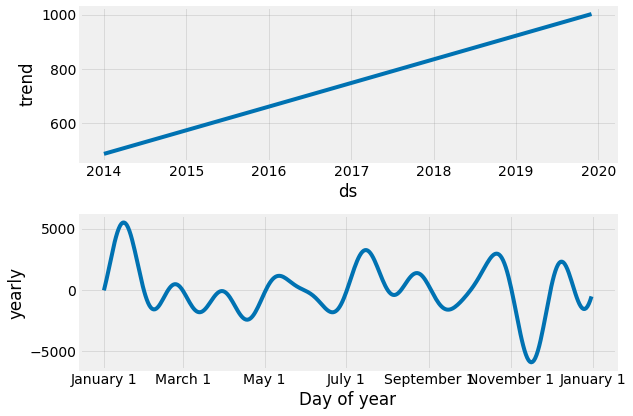

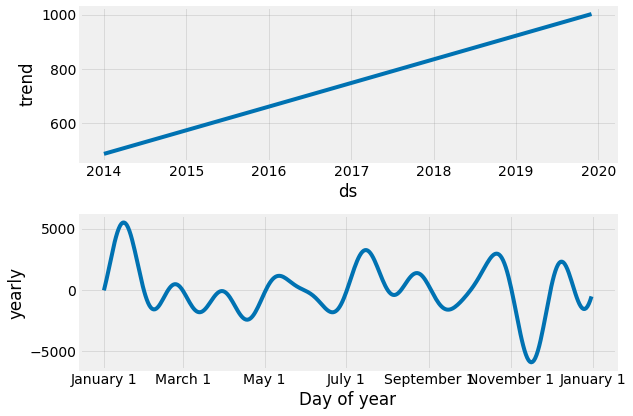

In [155]:
m_office.plot_components(forecast_office)

Furniture Category

In [156]:
furniture_y_df = furniture_y.to_frame()

In [157]:
furniture_y_df['ds'] = furniture_y_df.index

In [158]:
furniture_y_df.columns = ['y','ds']

In [159]:
furniture_y_df

,y,ds
Order Date,,
2014-01-01,480.194231,2014-01-01
2014-02-01,367.931600,2014-02-01
2014-03-01,857.291529,2014-03-01
2014-04-01,567.488357,2014-04-01
2014-05-01,432.049188,2014-05-01
2014-06-01,695.059242,2014-06-01
2014-07-01,601.169500,2014-07-01
2014-08-01,457.521656,2014-08-01
2014-09-01,992.353367,2014-09-01


In [160]:
m_furniture = Prophet()

In [161]:
m_furniture.fit(furniture_y_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [162]:
future_furniture = m_furniture.make_future_dataframe(periods=24,freq='MS')

In [163]:
future_furniture

,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01
...,...
67,2019-08-01
68,2019-09-01
69,2019-10-01
70,2019-11-01


In [164]:
forecast_furniture = m_furniture.predict(future_furniture)

In [165]:
forecast_furniture

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,726.057713,380.951145,681.085326,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,0.0,0.0,0.0,535.372051
1,2014-02-01,727.494023,306.457596,612.636007,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,0.0,0.0,0.0,451.116320
2,2014-03-01,728.791335,545.081952,854.917712,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,0.0,0.0,0.0,706.401580
3,2014-04-01,730.227645,477.594348,788.274583,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,0.0,0.0,0.0,630.086487
4,2014-05-01,731.617622,415.253933,731.316165,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,0.0,0.0,0.0,570.801960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-08-01,820.483484,493.254782,813.887023,820.483460,820.483504,-152.742582,-152.742582,-152.742582,-152.742582,-152.742582,-152.742582,0.0,0.0,0.0,667.740901
68,2019-09-01,821.919793,1209.404083,1530.591480,821.919768,821.919815,551.713042,551.713042,551.713042,551.713042,551.713042,551.713042,0.0,0.0,0.0,1373.632835
69,2019-10-01,823.309770,653.311226,961.958385,823.309743,823.309794,-13.792198,-13.792198,-13.792198,-13.792198,-13.792198,-13.792198,0.0,0.0,0.0,809.517572
70,2019-11-01,824.746079,1088.427922,1382.924246,824.746051,824.746105,413.144741,413.144741,413.144741,413.144741,413.144741,413.144741,0.0,0.0,0.0,1237.890821


In [166]:

forecast_furniture[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

,ds,yhat_lower,yhat_upper,yhat
60,2019-01-01,523.948934,846.140041,680.605855
61,2019-02-01,310.847029,630.578440,471.018150
62,2019-03-01,706.139713,1024.689905,860.015348
63,2019-04-01,597.194094,910.775218,761.302342
64,2019-05-01,473.219408,788.380790,631.589549
65,2019-06-01,451.958563,772.343136,609.811049
66,2019-07-01,614.072119,928.233251,770.752517
67,2019-08-01,493.254782,813.887023,667.740901
68,2019-09-01,1209.404083,1530.591480,1373.632835
69,2019-10-01,653.311226,961.958385,809.517572


Text(14.850000000000001, 0.5, 'Sales')

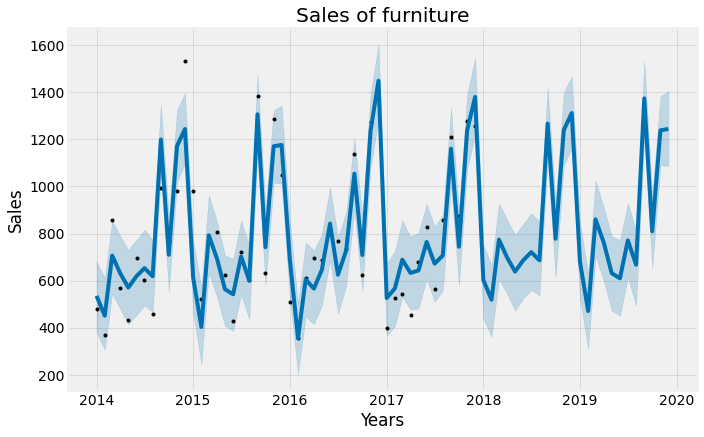

In [167]:
m_furniture.plot(forecast_furniture);
plt.title('Sales of furniture')
plt.xlabel('Years')
plt.ylabel('Sales')

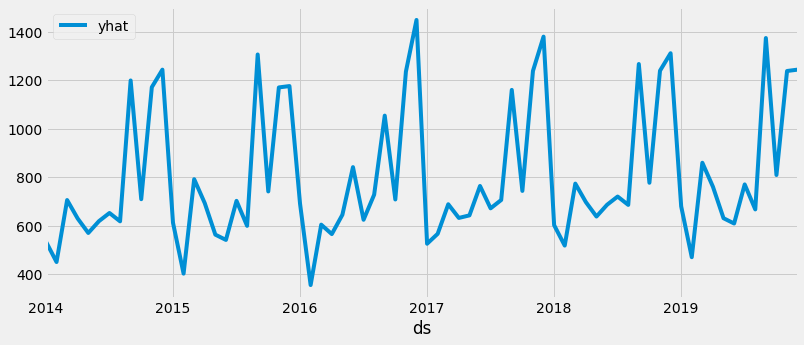

In [169]:
forecast_furniture.plot(x='ds',y='yhat',figsize=(12,5))

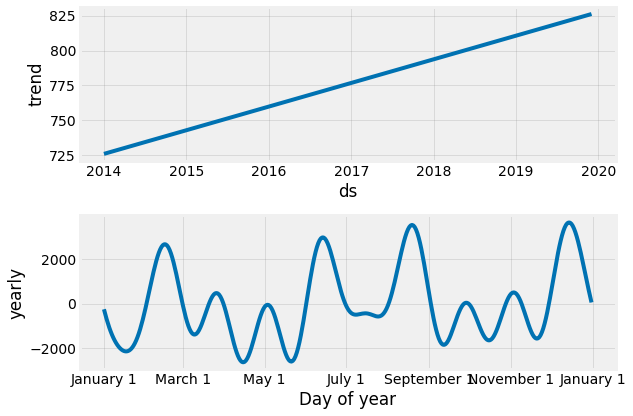

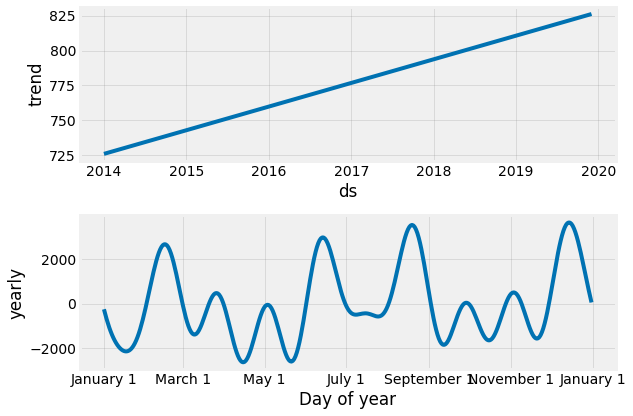

In [170]:
m_furniture.plot_components(forecast_furniture)